# Business Understanding

## Project Domain

Lingkungan Hidup

Proyek ini berfokus pada pengembangan sistem peringatan dini (Early Warning System) untuk potensi banjir. Latar belakang proyek ini terinspirasi oleh bencana **banjir bandang dan longsor yang baru-baru ini melanda wilayah Sumatera (Sumatera Barat dan sekitarnya)**, yang mengakibatkan kerugian material dan korban jiwa yang signifikan akibat curah hujan ekstrem yang tidak terantisipasi.

Meskipun terinspirasi dari kejadian di Sumatera, dalam pengembangan model awal ini, kami menggunakan data historis dari **PUSDATARU Jawa Tengah** sebagai studi kasus untuk melatih kecerdasan buatan dalam memprediksi pola hujan ekstrem yang berpotensi menyebabkan banjir berdasarkan tanggal dan lokasi.

## Problem Statements

1. Sulitnya memprediksi kejadian hujan ekstrem hanya dengan pengamatan manual.
2. Kurangnya sistem peringatan dini yang dapat memproses data historis curah hujan untuk memberikan estimasi risiko banjir di tingkat Kabupaten.
3. Keterlambatan informasi mengenai potensi bahaya hidrometeorologi kepada masyarakat.

## Goals

Membangun aplikasi Machine Learning yang dapat memprediksi label cuaca (Hujan/Potensi Banjir atau Tidak) berdasarkan pola waktu (Tanggal, Bulan) dan Lokasi (Kabupaten) dengan tingkat akurasi yang dapat diandalkan untuk mendukung pengambilan keputusan mitigasi bencana.

## Solution Statements

Mengembangkan model klasifikasi menggunakan algoritma **Random Forest Classifier**. Algoritma ini dipilih karena kemampuannya menangani data non-linear dan memberikan akurasi yang baik pada dataset dengan banyak fitur kategorikal (seperti nama Kabupaten). Solusi ini juga mencakup penanganan ketidakseimbangan data (imbalanced data) menggunakan teknik resampling.

# Data Understanding

## Dataset Description

Dataset yang digunakan adalah data rekapitulasi curah hujan harian dari PUSDATARU (Pusat Data dan Informasi Sumber Daya Air) Jawa Tengah. Dataset ini mencakup informasi tanggal, lokasi pos pengamatan, dan besaran curah hujan.

https://pusdataru.jatengprov.go.id/portal_data/curah_hujan

In [ ]:
# jelaskan cara membuat datasetnya

## Libary Requirements

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

dataset_path = '../../dataset/processed/data_training_gabungan.csv'
models_path = 'saved_models'
os.makedirs(models_path, exist_ok=True)

## Exploratory Data Abalysis

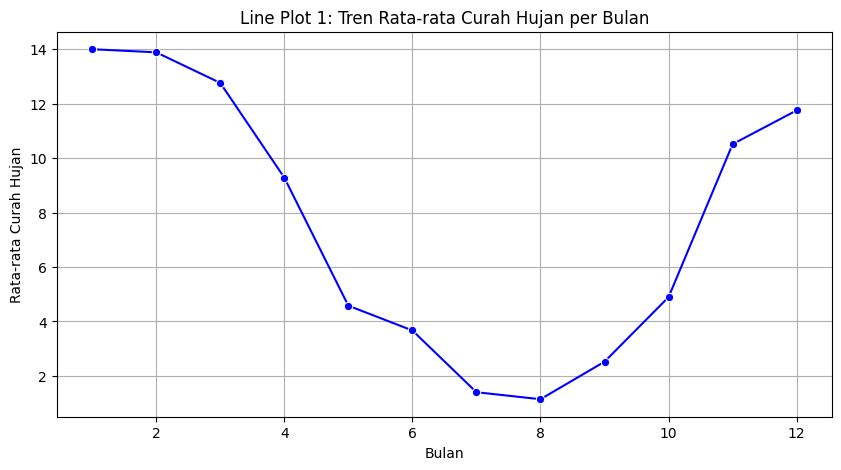

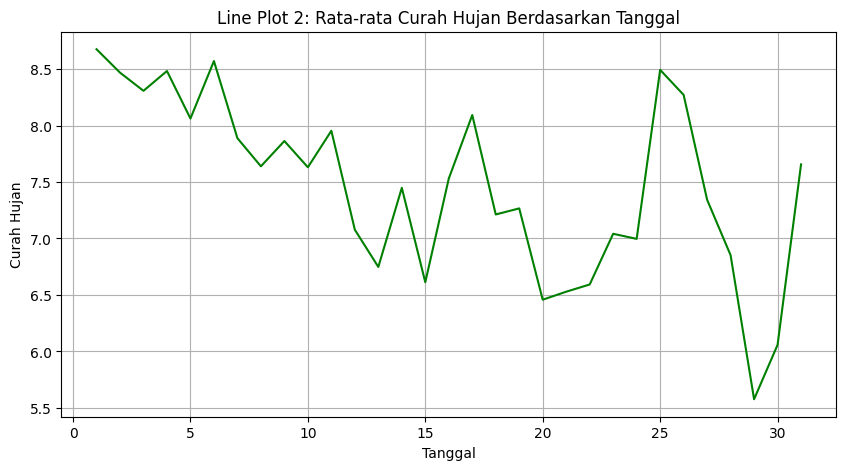

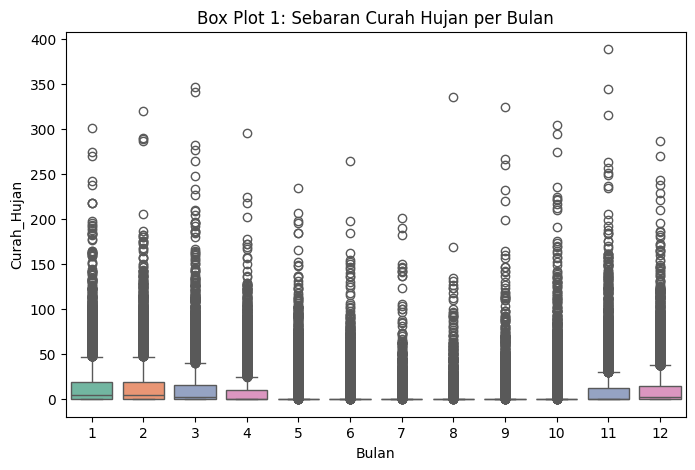

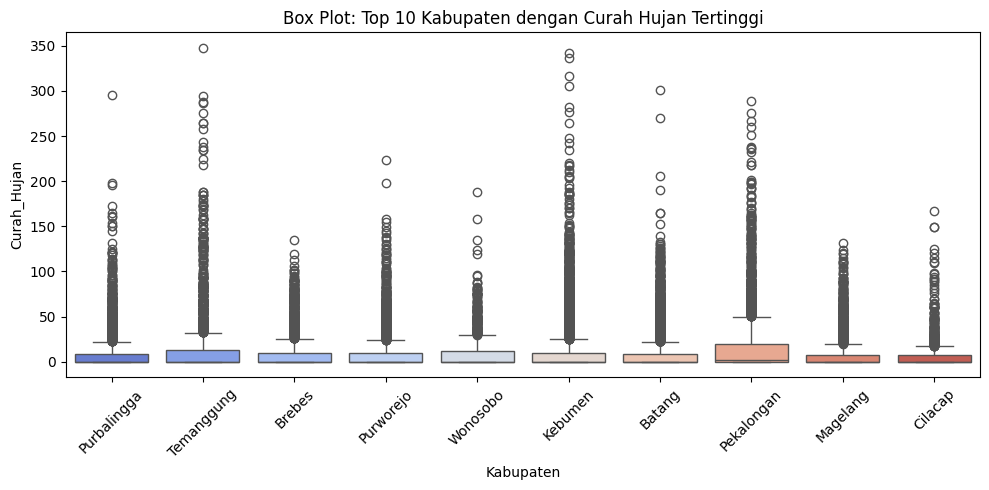

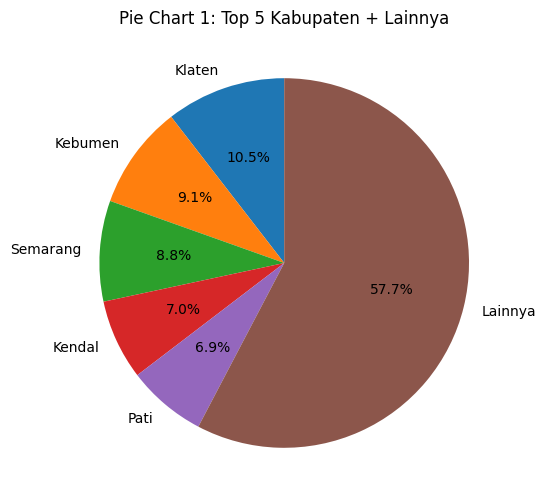

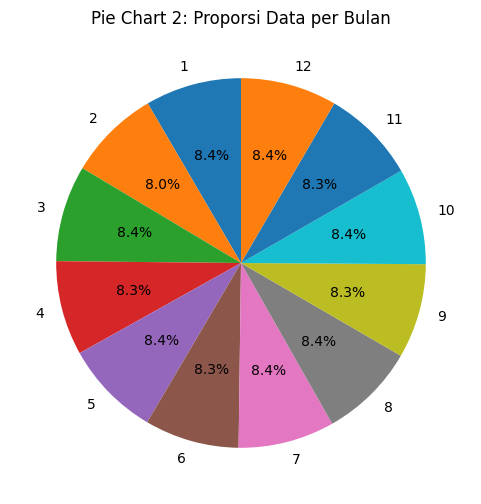

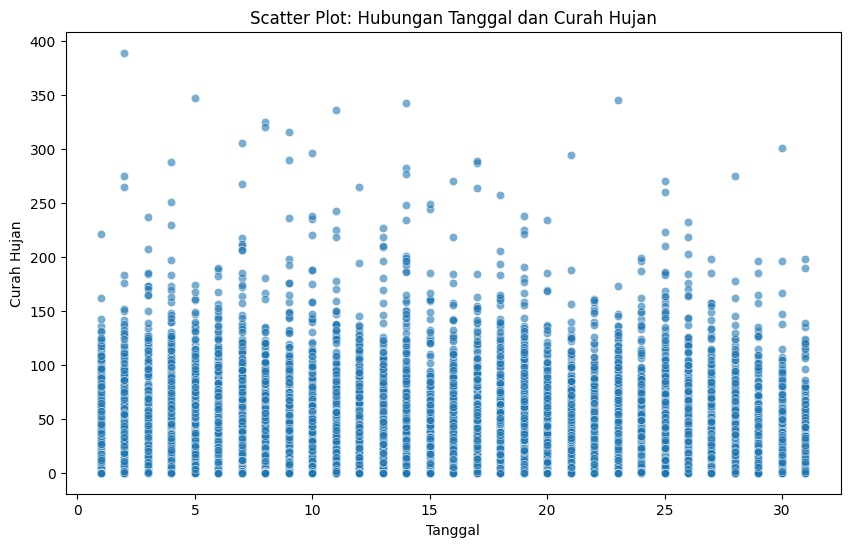

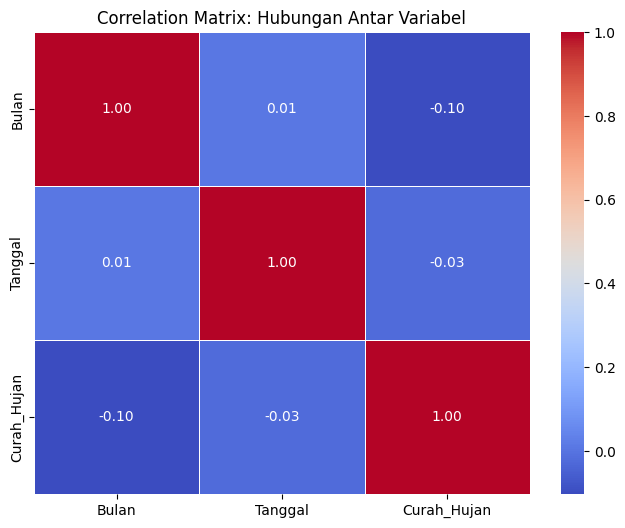

In [2]:
df = pd.read_csv(dataset_path)
plt.rcParams['figure.figsize'] = (12, 6)

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Bulan', y='Curah_Hujan', marker='o', errorbar=None, color='blue')
plt.title('Line Plot 1: Tren Rata-rata Curah Hujan per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata Curah Hujan')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Tanggal', y='Curah_Hujan', estimator='mean', errorbar=None, color='green')
plt.title('Line Plot 2: Rata-rata Curah Hujan Berdasarkan Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='Bulan', y='Curah_Hujan', data=df, hue='Bulan', palette='Set2', legend=False)
plt.title('Box Plot 1: Sebaran Curah Hujan per Bulan')
plt.show()

top10_kabupaten = (
    df[df["Kabupaten"].str.lower() != "unknown"]
    .groupby("Kabupaten")["Curah_Hujan"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

df_top10 = df[df["Kabupaten"].isin(top10_kabupaten)]

plt.figure(figsize=(10, 5))
sns.boxplot(
    x='Kabupaten',
    y='Curah_Hujan',
    data=df_top10,
    hue='Kabupaten',
    palette='coolwarm',
    legend=False
)
plt.title('Box Plot: Top 10 Kabupaten dengan Curah Hujan Tertinggi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

kab_counts = df[df["Kabupaten"].str.lower() != "unknown"]["Kabupaten"].value_counts()
top_kabupaten = kab_counts.head(5)
others = kab_counts.iloc[5:].sum()
top_kabupaten['Lainnya'] = others

plt.figure(figsize=(6, 6))
top_kabupaten.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart 1: Top 5 Kabupaten + Lainnya')
plt.ylabel('')
plt.show()

plt.figure(figsize=(6, 6))
df['Bulan'].value_counts().sort_index().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart 2: Proporsi Data per Bulan')
plt.ylabel('')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tanggal', y='Curah_Hujan', data=df, alpha=0.6)
plt.title('Scatter Plot: Hubungan Tanggal dan Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan')
plt.show()

plt.figure(figsize=(8, 6))
numeric_cols = ['Bulan', 'Tanggal', 'Curah_Hujan']
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Hubungan Antar Variabel')
plt.show()

# Data Preparation

## Dataset Information

In [3]:
df = pd.read_csv(dataset_path)

print("Info Dataset:")
print(df.info())
print("\nJumlah Missing Values:")
print(df.isnull().sum())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137260 entries, 0 to 137259
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         137260 non-null  object 
 1   Tahun        137260 non-null  int64  
 2   Bulan        137260 non-null  int64  
 3   Tanggal      137260 non-null  int64  
 4   Nama Pos     137260 non-null  object 
 5   Kabupaten    137260 non-null  object 
 6   Curah_Hujan  137260 non-null  float64
 7   Label        137260 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 8.4+ MB
None

Jumlah Missing Values:
Date           0
Tahun          0
Bulan          0
Tanggal        0
Nama Pos       0
Kabupaten      0
Curah_Hujan    0
Label          0
dtype: int64


## Dataset Transformation

In [ ]:
df = df.dropna(subset=['Curah_Hujan', 'Kabupaten'])

df_major = df[df['Label'] == 0]
df_minor = df[df['Label'] == 1]

df_minor_up = resample(df_minor, replace=True, n_samples=len(df_major), random_state=42)
df_bal = pd.concat([df_major, df_minor_up])

print(f"Jumlah data setelah balancing:\n{df_bal['Label'].value_counts()}")

encoder = OneHotEncoder(handle_unknown='ignore')
kab_encoded = encoder.fit_transform(df_bal[['Kabupaten']]).toarray()
kab_cols = encoder.get_feature_names_out(['Kabupaten'])

joblib.dump(encoder, os.path.join(models_path, 'encoder_kabupaten.pkl'))
print("Encoder berhasil diproses dan disimpan.")

Jumlah data setelah balancing:
Label
0    88610
1    88610
Name: count, dtype: int64
Encoder berhasil diproses dan disimpan.


In [ ]:
# bisa menggunakan auto encoder atau manual menggunakan bins

## Determine Variabels

In [ ]:
fitur = df_bal[['Bulan', 'Tanggal', 'Kabupaten']]

df_final = pd.DataFrame({
    "Bulan": fitur["Bulan"].values,
    "Tanggal": fitur["Tanggal"].values
})

df_ohe = pd.DataFrame(kab_encoded, columns=kab_cols)
X = pd.concat([df_final, df_ohe], axis=1)
y = df_bal['Label']

joblib.dump(list(X.columns), os.path.join(models_path, 'feature_columns.pkl'))

print("Fitur dan Label siap.")

Fitur dan Label siap.


# Modeling

## Modeling classification / clustering

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=150, random_state=42)

print("Sedang melatih model...")
model.fit(X_train, y_train)
print("Training selesai.")

Sedang melatih model...
Training selesai.


In [20]:
# ada 2 plihihan bisa menggunakan supervised learning / unsupervised learning

# Evaluation

## Model evaluation classification / clustering

In [ ]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {acc*100:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Akurasi Model: 73.14%

Confusion Matrix:
[[12049  5648]
 [ 3872 13875]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72     17697
           1       0.71      0.78      0.74     17747

    accuracy                           0.73     35444
   macro avg       0.73      0.73      0.73     35444
weighted avg       0.73      0.73      0.73     35444



In [22]:
# untuk supervised bisa menggunakan mse, rmse, atau confusion matrix

In [23]:
# untuk unsupervised bisa gunakan sillouete atau davies bouldin

# Deployment

## Model Simulation

In [8]:
# Simpan Model Final
joblib.dump(model, os.path.join(models_path, 'model_rf.pkl'))
print(f"Model berhasil disimpan di folder {models_path}")

Model berhasil disimpan di folder saved_models


## Save Model

In [3]:
def prediksi_banjir(tanggal_input, kabupaten):
    """
    tanggal_input: string dengan format 'YYYY-MM-DD' (contoh: '2025-01-30')
    kabupaten: nama kabupaten (contoh: 'Semarang')
    """
    try:
        dt = pd.to_datetime(tanggal_input) 
        bulan = dt.month
        tanggal = dt.day
    except:
        return "Error: Format tanggal salah. Gunakan YYYY-MM-DD"

    try:
        loaded_model = joblib.load(os.path.join(models_path, 'model_rf.pkl'))
        loaded_encoder = joblib.load(os.path.join(models_path, 'encoder_kabupaten.pkl'))
        feature_cols = joblib.load(os.path.join(models_path, 'feature_columns.pkl'))
    except FileNotFoundError:
        return "Error: Model belum dilatih atau file tidak ditemukan."
    
    input_data = pd.DataFrame({'Bulan': [bulan], 'Tanggal': [tanggal]})
    
    try:
        kab_encoded = loaded_encoder.transform([[kabupaten]]).toarray()
    except ValueError:
        return "Error: Nama Kabupaten tidak dikenali di dalam dataset."
        
    kab_df = pd.DataFrame(kab_encoded, columns=loaded_encoder.get_feature_names_out(['Kabupaten']))
    
    final_input = pd.concat([input_data, kab_df], axis=1)
    final_input = final_input.reindex(columns=feature_cols, fill_value=0)
    
    prediction = loaded_model.predict(final_input)
    
    hasil = "Hujan" if prediction[0] == 1 else "Tidak"
    return f"Prediksi cuaca tgl {tanggal_input} di {kabupaten}: {hasil}"

print(prediksi_banjir('2025-01-15', 'Semarang'))
print(prediksi_banjir('2024-08-17', 'Surakarta'))

c:\Users\ramah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Prediksi cuaca tgl 2025-01-15 di Semarang: Hujan
Prediksi cuaca tgl 2024-08-17 di Surakarta: Tidak


c:\Users\ramah\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
